# **Galah Data Pipeline**

In [20]:
from analysis import XDPipeline
from analysis import galah_filter

In [21]:
# Set true to rerun XD analysis - approx 10 hours for 100 iterations with 3 repeats per gaussian component
rerun_XD = False

## **Importing/ Filtering Galah Data**

| **Dataset**         | **Variable**                     | **Description** |
|---------------------|---------------------------------|----------------|
| **Galah Data**      | `galah_data_path`              | Contains stellar data from Galah DR3, including elemental abundances. |
| **Dynamical Data**  | `galah_data_dynamics_path`     | Contains dynamical parameters from *Bovy 2015*, such as Energy, Eccentricity, Apocentre, and Action Variables (VAC). |
| **Gaia Data**       | `galah_data_gaia_path`         | Contains Gaia data, including photogeometric distance estimates from *Bailer-Jones 2021* (VAC). |


###  galah_filter
- Preforms a series of data quality cuts outlined by docstring below


In [22]:
galah_data_path = 'data/raw/Galah_DR3/GALAH_DR3_main_allstar_v2.fits'
galah_data_dynamics_path = 'data/raw/Galah_DR3/GALAH_DR3_VAC_dynamics_v2.fits'
galah_data_gaia_path = 'data/raw/Galah_DR3/GALAH_DR3_VAC_GaiaEDR3_v2.fits'

galah_data_filtered_path = 'data/filtered/Galah/Galah_data_filtered_1061.csv'

In [23]:
?galah_filter

Signature: galah_filter(star_data_in, dynamics_data_in, gaia_data_in, save_path=None)
Docstring:
Applies quality cuts to GALAH, Gaia, and dynamics datasets to produce 
a refined sample of metal-poor, high-eccentricity stars. 

This function filters stars based on data quality, chemical abundances, 
orbital properties, and distance uncertainties.

Parameters
----------
star_data_in : str, Table, np.recarray, or pd.DataFrame
    GALAH stellar data, provided as a file path (CSV, FITS, TXT) or an 
    Astropy Table, NumPy recarray, or Pandas DataFrame.

dynamics_data_in : str, Table, np.recarray, or pd.DataFrame
    Dynamics dataset containing orbital properties (e.g., energy, 
    eccentricity, actions).

gaia_data_in : str, Table, np.recarray, or pd.DataFrame
    Gaia dataset providing distances and photogeometric uncertainties. 

save_path : str, optional
    If provided, saves the filtered dataset as a FITS file at the specified path.

Returns
-------
Table
    An Astropy Table contain

In [24]:
galah_processed_data = galah_filter(galah_data_path, galah_data_dynamics_path, galah_data_gaia_path, save_path=galah_data_filtered_path)

INFO:root:Initial number of stars: 588571
INFO:root:Final number of stars: 1061
INFO:root:Fraction retained: 0.18%
INFO:root:Filtered dataset saved to data/filtered/Galah/Galah_data_filtered_1061.csv


## **XD Pipeline**
- The XD pipeline contains the following processes and functionalities

In [25]:
?XDPipeline

Init signature:
XDPipeline(
    star_data: Union[astropy.table.table.Table, numpy.rec.recarray, pandas.core.frame.DataFrame],
    data_keys: List[str],
    data_err_keys: List[str],
)
Docstring:     
A pipeline for performing Extreme Deconvolution (XD) using a Gaussian Mixture Model (GMM).

Aims at analysing and fitting multi-dimensional stellar datasets.

The pipeline follows these key steps:

1. **Initialisation** (`__init__`):
   - Takes in stellar data as an Astropy Table, NumPy recarray, or Pandas DataFrame.
   - Extracts relevant features defined by `data_keys` and their errors `data_err_keys`.

2. **Extreme Deconvolution (XD)** (`run_XD`):
   - Normalises the dataset for efficient convergence.
   - Runs XD over a specified range of Gaussian components.
   - Iterates through multiple random initialisations to ensure robust fitting.
   - Uses BIC and AIC scores to evaluate model performance.
   - Optionally saves results to a file for later analysis.

3. **Model Comparison & Selec

### **Initialisation of Pipeline**
- Imports revelent total data set and the keys for the data features (and corrosponding errors of intrest)

In [26]:
galah_data_keys = ['fe_h', 'alpha_fe', 'Na_fe', 'Al_fe', 'Mn_fe', 'Y_fe', 'Ba_fe', 'Eu_fe', 'Mg_Cu', 'Mg_Mn', 'Ba_Eu', 'Energy']
galah_data_error_keys = ['e_fe_h', 'e_alpha_fe', 'e_Na_fe', 'e_Al_fe', 'e_Mn_fe', 'e_Y_fe', 'e_Ba_fe', 'e_Eu_fe', 'e_Mg_Cu', 'e_Mg_Mn', 'e_Ba_Eu', 'e_Energy']

galah_pipeline = XDPipeline(galah_processed_data, galah_data_keys, galah_data_error_keys)

### **XD Run Overview**  

#### **Parameters**  

| **Parameter**                     | **Value**  |
|------------------------------------|------------|
| **Max EM Iterations**              | \(10^9\)   |
| **Number of Gaussian Components**  | 0 – 10     |
| **Repeats per Gaussian Component** | 3          |
| **Initializations per Repeat**     | 100        |

#### **Stored Data**  
- Achieved Weights, Means, and Covariances for each run  
- Model Evaluation Metrics:  
  - AIC (Akaike Information Criterion)
  - BIC (Bayesian Information Criterion)

In [27]:
?XDPipeline.run_XD

Signature:
XDPipeline.run_XD(
    self,
    gauss_component_range: Tuple[int, int] = (1, 10),
    max_iterations: int = 1000000000,
    n_repeats: int = 3,
    n_init: int = 100,
    save_path: Optional[str] = None,
) -> None
Docstring:
Run Extreme Deconvolution (XD) for a range of Gaussian components with multiple random initializations.
The results are evaluated using BIC and AIC for model selection.

Parameters
----------
gauss_component_range : Tuple[int, int]
    Range of Gaussian components to test, specified as (min, max).
max_iterations : int
    Maximum number of EM iterations per XD run.
n_repeats : int
    Number of complete repetitions of the initialization process.
n_init : int
    Number of random initializations per component count.
save_path : Optional[str]
    Path to save XD results. If None, results are not saved.

Raises
------
ValueError
    If `gauss_component_range` is invalid.
TypeError
    If `n_repeats`, `n_init`, or `max_iterations` are not positive integers.

In [28]:
if rerun_XD:
    galah_pipeline.run_XD(gauss_component_range=(1,10), max_iterations=int(1e9), n_repeats=3, n_init=100, save_path='XD_Results/Galah/gallah_XD_2_3_23.pkl')

### **Run Results Analysis** 

#### **Overall**

| **Overall Results Analysis**                        | **Details** |
|---------------------------------|------------|
| **Performance Metric**          | BIC Score |
| **Filters Applied**             | None |
| **Saves**                       | Gaussian Weights, Means, and Covariances |
| **Records**                     | Corresponding BIC score |

#### **Filtered**

| **Filtered Results Analysis**   | **Details** |
|---------------------------------|------------|
| **Performance Metric**          | BIC Score |
| **Filters Applied**             | 5 Gaussian Components |
| **Saves**                       | Gaussian Weights, Means, and Covariances |
| **Records**                     | Corresponding BIC score |


In [29]:
?XDPipeline.compare_XD

Signature:
XDPipeline.compare_XD(
    self,
    opt_metric='BIC',
    n_gauss_filter: Optional[int] = None,
    repeat_no_filter: Optional[int] = None,
    save_path: Optional[str] = None,
) -> None
Docstring:
Analyse Extreme Deconvolution (XD) results using BIC or AIC.
This method identifies the best-fit model, summarizes failed runs, and visualizes score distributions.
If no filters are applied, the analysis is performed on all results. Otherwise, it is performed on filtered results.

Parameters
----------
opt_metric : str
    Optimization metric ('BIC' or 'AIC').
n_gauss_filter : Optional[int]
    Specific number of Gaussian components to filter results by.
repeat_no_filter : Optional[int]
    Specific repeat cycle to filter results by.
save_path : Optional[str]
    Path to load XD results if not already stored in the class.

Raises
------
ValueError
    If results are not available in the class and no valid `save_path` is given.
ValueError
    If `opt_metric` is not 'BIC' or 'AIC'.

 Best Overall BIC Score: 28116.4021 occurred at:
   - Gaussian Components (n_gauss): 3
   - Repeat cycle (n): 2
   - Initialisation (i): 52
 The following filters were applied: {'n_gauss': 5, 'repeat': None}
 Best BIC Score from filtered inputs: 28863.1862 occurred at:
   - Gaussian Components (n_gauss): 5
   - Repeat cycle (n): 0
   - Initialisation (i): 39
Table of Number of Gaussians vs Number of Failed XD Runs
+----+-----------------+----------------------+------------------+
|    |   No. Gaussians |   No. Failed XD runs |   Total No. Runs |
|----+-----------------+----------------------+------------------|
|  0 |               1 |                    0 |              300 |
|  1 |               2 |                    0 |              300 |
|  2 |               3 |                    0 |              300 |
|  3 |               4 |                    0 |              300 |
|  4 |               5 |                    0 |              300 |
|  5 |               6 |                    0 

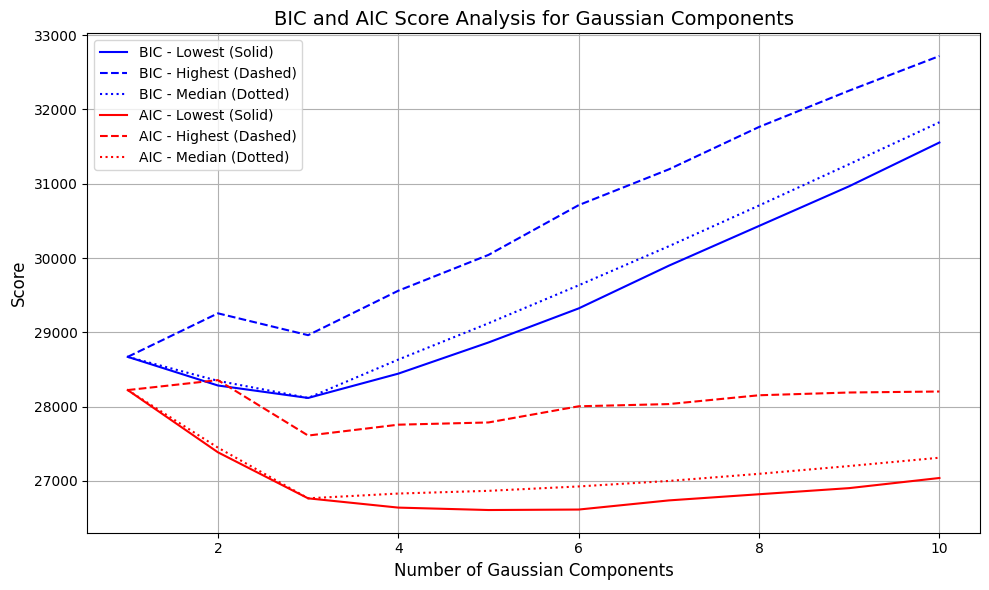

In [30]:
galah_pipeline.compare_XD(opt_metric = 'BIC', n_gauss_filter = 5, repeat_no_filter = None, save_path='XD_Results/Galah/gallah_XD_2_3_23.pkl')

### **Determine Responsibilities and Assignment**

- Use the gaussian components from the best XD run of filter subset (best filtered)

In [31]:
?XDPipeline.assigment_XD

Signature: XDPipeline.assigment_XD(self, assignment_metric='best')
Docstring:
Assign stars to Gaussian components based on the best-fit XD model.
Computes the responsibility of each gaussians for each star and assigns it accordingly.

Parameters
----------
assignment_metric : str
    Selection criteria for the best-fit model ('best' or 'best filtered').

Raises
------
ValueError
    If no XD results are available.
ValueError
    If an invalid `assignment_metric` is specified.

Returns
-------
None
    Updates `star_data` in place to include probability assignments:
        - `prob_gauss_{i}`: Probability of belonging to the i-th Gaussian component.
        - `max_gauss`: Index of the component with the highest probability (1-based index).
File:      ~/Desktop/MPhil_DIS/Project/analysis/XD.py
Type:      function

In [32]:
galah_pipeline.assigment_XD(assignment_metric = 'best filtered')

Assigning stars to Gaussian components based on the best filtered XD model.
This has been optimised for the BIC score and returned the results:
 Best BIC Score: 28863.1862 occurred at:
   - Gaussian Components (n_gauss): 5
   - Repeat cycle (n): 0
   - Initialisation (i): 39


### **Print Summary of Gaussian Components and Assigment**


In [33]:
?XDPipeline.table_results_XD

Signature: XDPipeline.table_results_XD(self) -> pandas.core.frame.DataFrame
Docstring:
Generate a summary table of the Extreme Deconvolution (XD) results showing the mean and error values of each gaussian in high dimensional space.

For each gaussian the table includes:
- Component Name (indexed numerically)
- XD assigned Weight (%)
- Count of assigned stars to (should reflect the weights)
- Mean values and standard deviations for each feature parameter

Returns
-------
pd.DataFrame
    A formatted summary of the Gaussian components fitted by XD.
File:      ~/Desktop/MPhil_DIS/Project/analysis/XD.py
Type:      function

In [34]:
galah_gauss_summary = galah_pipeline.table_results_XD()


Summary of GMM Fit Result for GALAH-Gaia Sample
+----+-------------+--------------+---------+--------------+-------------+--------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+--------------+-----------------------+
|    | Component   |   Weight (%) |   Count | fe_h         | alpha_fe    | Na_fe        | Al_fe        | Mn_fe        | Y_fe        | Ba_fe       | Eu_fe       | Mg_Cu       | Mg_Mn       | Ba_Eu        | Energy                |
+====+=============+==============+=========+==============+=============+==============+==============+==============+=============+=============+=============+=============+=============+==============+=======================+
|  0 | Component 4 |         35.4 |     160 | -0.95 ± 0.16 | 0.11 ± 0.05 | -0.26 ± 0.07 | -0.16 ± 0.08 | -0.36 ± 0.08 | 0.08 ± 0.06 | 0.38 ± 0.15 | 0.47 ± 0.07 | 0.61 ± 0.05 | 0.46 ± 0.10 | -0.09 ± 0.18 | -152725.24 ± 13040.21 |
+----+-------------+--------------+

### **Plot Results**  
- Generates a 2D plot of **Extreme Deconvolution (XD)** results.  
- Stars are colored by their assigned Gaussian component.  
- Gaussian components are shown as confidence ellipses.  
- Includes marginal histograms and a bar chart of component weights.  
- Confidence interval adjustable via `z_score` (default: 2 ~ 95%). 

In [38]:
?XDPipeline.plot_XD

Signature:
XDPipeline.plot_XD(
    self,
    x_key: str,
    y_key: str,
    z_score: Optional[float] = 2,
) -> None
Docstring:
Creates a 2D plot of the Extreme Deconvolution (XD) results, displaying:
- Individual stars colored by their assigned Gaussian component
- Gaussian mixture model (GMM) components as confidence ellipses
- Marginal histograms and KDE distributions for each axis
- A bar chart representing the relative weight of each Gaussian component

The confidence ellipses are scaled according to a given z-score, providing 
a visual representation of the spread of each Gaussian component.

Parameters
----------
x_key : str
    The column name corresponding to the x-axis variable.
y_key : str
    The column name corresponding to the y-axis variable.
z_score : float, optional
    The z-score defining the confidence interval for the Gaussian ellipses.
    Defaults to 2, corresponding to a 95% confidence interval.

Raises
------
ValueError
    If the XD analysis has not been perfo

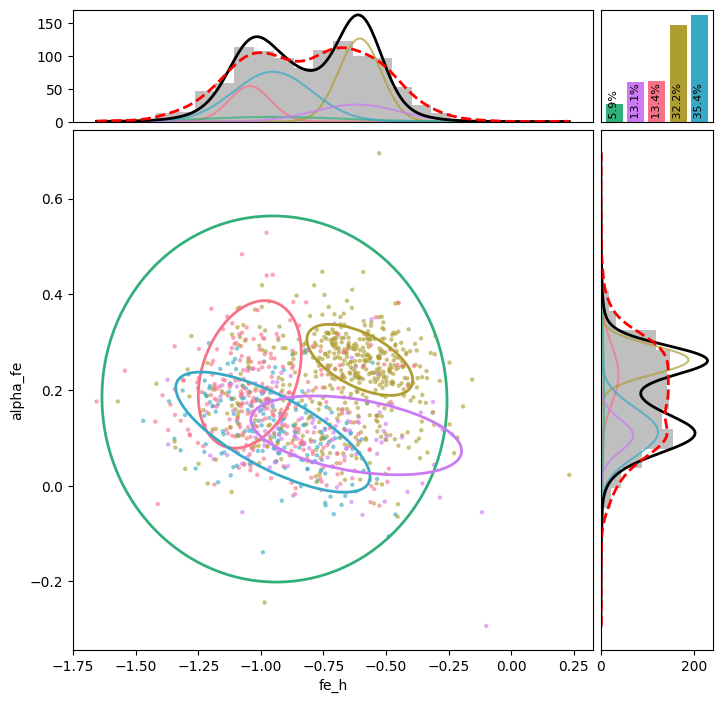

In [39]:
galah_pipeline.plot_XD( x_key = 'fe_h', y_key='alpha_fe', z_score = 2)

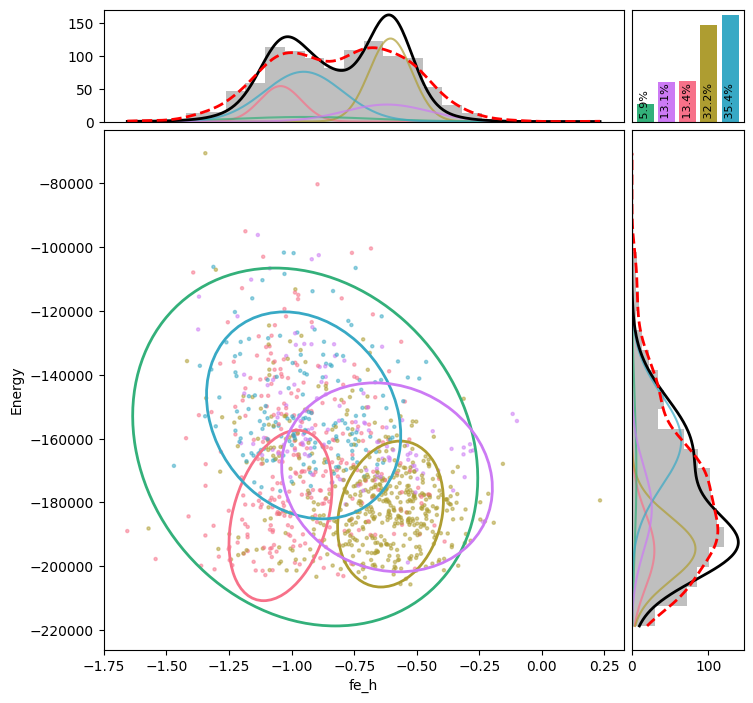

In [37]:
galah_pipeline.plot_XD( x_key = 'fe_h', y_key='Energy', z_score = 2)

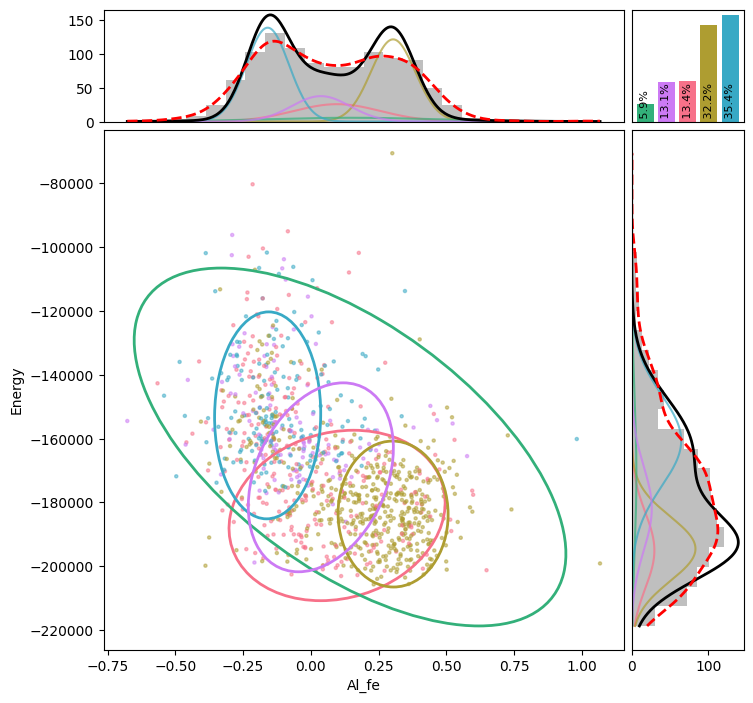

In [40]:
galah_pipeline.plot_XD( x_key = 'Al_fe', y_key='Energy', z_score = 2)

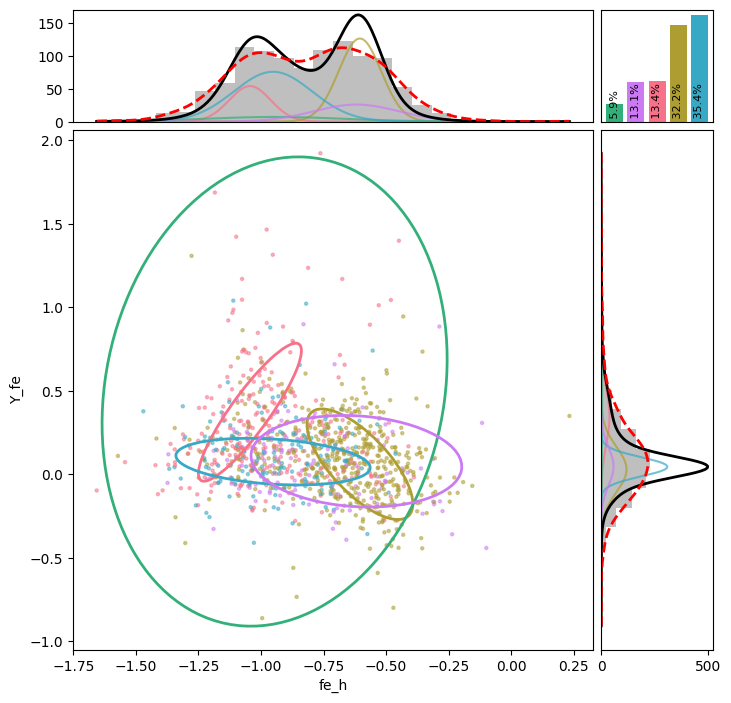

In [41]:
galah_pipeline.plot_XD( x_key = 'fe_h', y_key='Y_fe', z_score = 2)

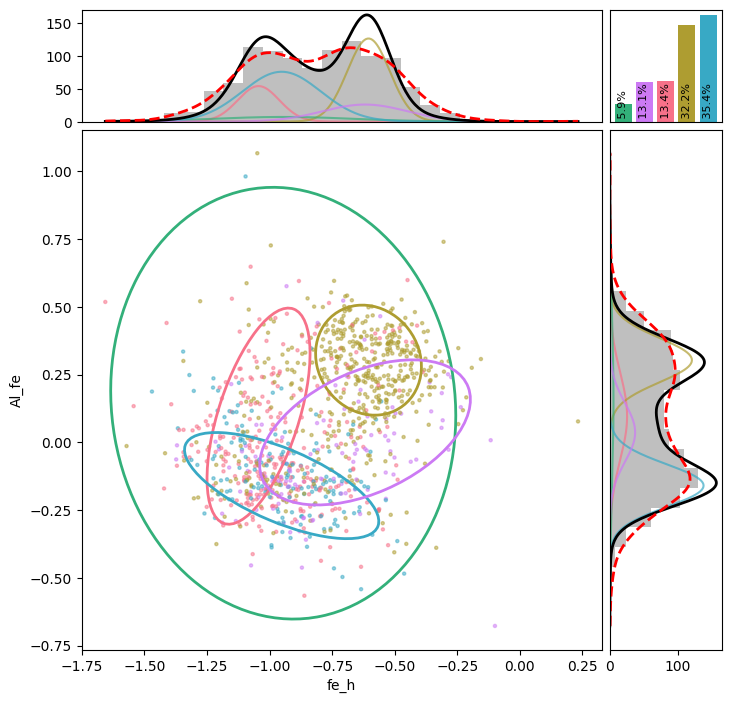

In [ ]:
galah_pipeline.plot_XD(x_key = 'fe_h', y_key='Al_fe', z_score = 2)

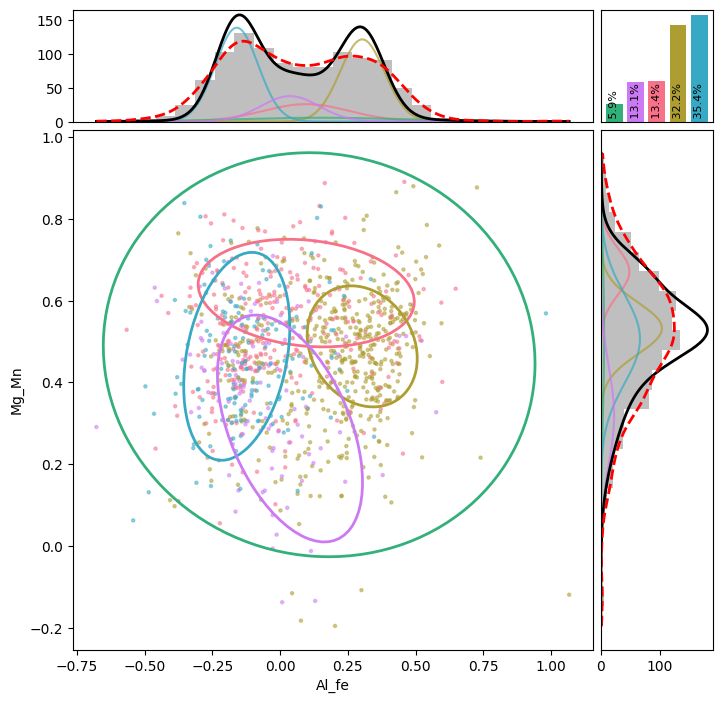

In [43]:
galah_pipeline.plot_XD( x_key = 'Al_fe', y_key='Mg_Mn', z_score = 2)